In [ ]:
!pip install torchinfo
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torchvision import datasets, transforms, models
from tqdm.auto import tqdm
from torchinfo import summary
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryF1Score, ConfusionMatrix

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
dataset_path = r'/content/drive/MyDrive/brain_tumor_dataset'

files = []
labels = []

for label in ['yes','no']:
    for dirname, _, filenames in os.walk(os.path.join(dataset_path,label)):
        for filename in filenames:
            files.append(os.path.join(dirname, filename))
            labels.append(1 if label == 'yes' else 0)

len(files), len(labels)

(253, 253)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc, train_f1 = 0, 0, 0
    F1 = BinaryF1Score().to(device)

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        train_f1 += F1(y_pred_class, y).item()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    train_f1 = train_f1 / len(dataloader)
    return train_loss, train_acc, train_f1

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    F1 = BinaryF1Score().to(device)

    # Setup test loss and test accuracy values
    test_loss, test_acc, test_f1 = 0, 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            test_f1 += F1(test_pred_labels, y).item()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    test_f1 = test_f1 / len(dataloader)
    return test_loss, test_acc, test_f1

In [ ]:

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "train_f1": [],
        "test_f1": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_f1 = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc, test_f1 = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"train_f1: {train_f1:.4f} | "
            f"test_f1: {test_f1:.4f}"

        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["train_f1"].append(train_f1)
        results["test_f1"].append(test_f1)


    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
def plot_loss_curves(result):

    # Get the loss values of the results dictionary (training and test)
    loss = result['train_loss']
    test_loss = result['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    f1 = results['train_f1']
    test_f1 = results['test_f1']
    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(24, 7))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot F1 score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1, label='train_f1')
    plt.plot(epochs, test_f1, label='test_f1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.legend()

In [ ]:
auto_transforms = models.ResNet18_Weights.IMAGENET1K_V1.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
batch_size = 64
# Change Tranforms accordong to the model
transform = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])
}
test_data = datasets.ImageFolder('/content/drive/MyDrive/brain_tumor_dataset', transform = transform["train"])
train_data = datasets.ImageFolder('//content/drive/MyDrive/brain_tumor_dataset',  transform = transform["test"])

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Change model
model = models.resnet18(models.ResNet18_Weights.IMAGENET1K_V1).to(device)

#Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.2),
    nn.Linear(128, 2),
    ).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(


Model Summary

In [ ]:

summary(model=model,
        input_size=(batch_size, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 224, 224]    [64, 2]              --                   Partial
├─Conv2d (conv1)                         [64, 3, 224, 224]    [64, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [64, 64, 112, 112]   [64, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [64, 64, 112, 112]   [64, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [64, 64, 112, 112]   [64, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [64, 64, 56, 56]     [64, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [64, 64, 56, 56]     [64, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [64, 64, 56, 56]     [64, 64, 56, 56]     (36,864)             False
│    │    

Training the model

In [ ]:
#Tune hyperparameters
NUM_EPOCHS = 30
loss_func = nn.CrossEntropyLoss()
optimizer = opt.SGD(model.parameters(), lr =0.0005, momentum = 0.9)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

pt_results = train(model=model,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_func,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7713 | train_acc: 0.4940 | test_loss: 0.7154 | test_acc: 0.3947 | train_f1: 0.5506 | test_f1: 0.0899
Epoch: 2 | train_loss: 0.7372 | train_acc: 0.5386 | test_loss: 0.7081 | test_acc: 0.4497 | train_f1: 0.5783 | test_f1: 0.2559
Epoch: 3 | train_loss: 0.6722 | train_acc: 0.5644 | test_loss: 0.6903 | test_acc: 0.5208 | train_f1: 0.6266 | test_f1: 0.4106
Epoch: 4 | train_loss: 0.6898 | train_acc: 0.5964 | test_loss: 0.6702 | test_acc: 0.5770 | train_f1: 0.6413 | test_f1: 0.5223
Epoch: 5 | train_loss: 0.6099 | train_acc: 0.6874 | test_loss: 0.6420 | test_acc: 0.6452 | train_f1: 0.7261 | test_f1: 0.6436
Epoch: 6 | train_loss: 0.5813 | train_acc: 0.7309 | test_loss: 0.6086 | test_acc: 0.6790 | train_f1: 0.7579 | test_f1: 0.6941
Epoch: 7 | train_loss: 0.5058 | train_acc: 0.7596 | test_loss: 0.5652 | test_acc: 0.6961 | train_f1: 0.7919 | test_f1: 0.7254
Epoch: 8 | train_loss: 0.4965 | train_acc: 0.7834 | test_loss: 0.5221 | test_acc: 0.7272 | train_f1: 0.8132 | test_f1:

Training and Testing Graphs

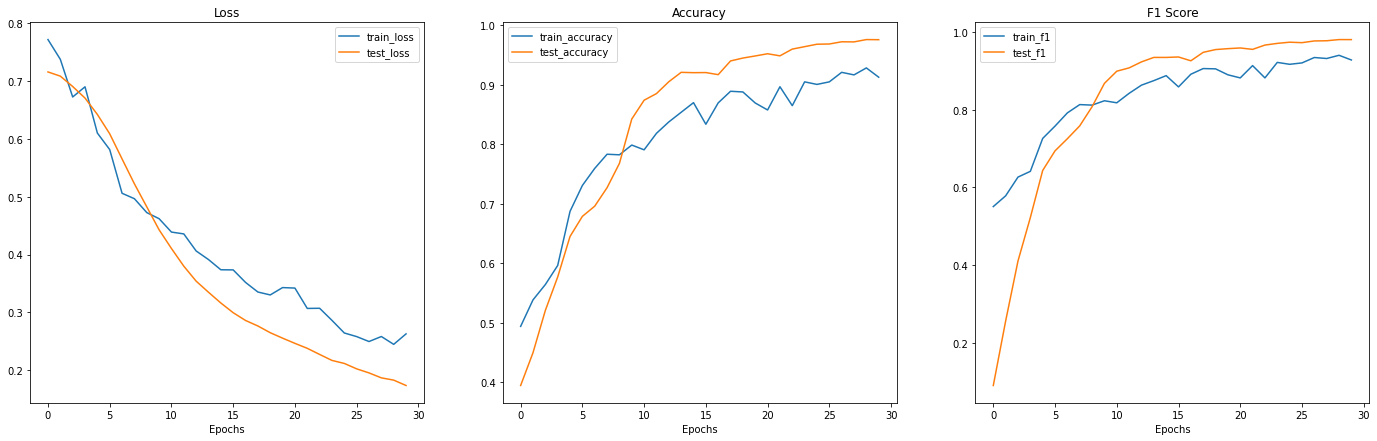

In [ ]:
plot_loss_curves(pt_results)

CONFUSION MATRIX

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def CF(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):

    # Put model in eval mode
    model.eval()
    y_pred = []
    y_true = []
    with torch.inference_mode():

        for (X, y) in dataloader:
          X,y = X.to(device),y.to(device)
          output = model(X)
          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Predicted Value

          y = y.data.cpu().numpy()
          y_true.extend(y) # Save True Value


    cf_matrix = confusion_matrix(y_true, y_pred)
    precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
    recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
    f1_score  = 2*precision*recall / (precision + recall)

    print("\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(precision,recall,f1_score))

    names = ['True Neg','False Pos','False Neg','True Pos']

    counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

    percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names,counts,percentages)]

    labels = np.asarray(labels).reshape(2,2)
    return (sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues'))


Precision=0.981
Recall=0.981
F1 Score=0.981


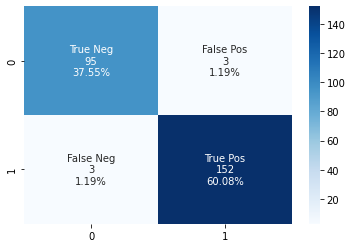

In [ ]:
CF(model,test_loader)

In [ ]:
PATH = 'model.pt'
torch.save(model, PATH)

In [ ]:
# model = torch.load(PATH)
# model.eval()